In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
import seaborn as sns
import random
from sklearn.utils import class_weight

/home/parmeet/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/parmeet/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

def normalize_image(ima):
    return (ima - np.min(ima))/(np.max(ima) - np.min(ima))

In [3]:
from PIL import Image
from vis.visualization import visualize_cam

In [4]:
def add_brightness(image):
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    image_HLS = np.array(image_HLS, dtype = np.float64) 
    random_brightness_coefficient = np.random.uniform()+0.5 ## generates value between 0.5 and 1.5
    image_HLS[:,:,1] = image_HLS[:,:,1]*random_brightness_coefficient ## scale pixel values up or down for channel 1(Lightness)
    image_HLS[:,:,1][image_HLS[:,:,1]>255]  = 255 ##Sets all values above 255 to 255
    image_HLS = np.array(image_HLS, dtype = np.uint8)
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

In [5]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions


base_model = ResNet50(
    input_shape=(224,224,3),
    weights='imagenet',
    include_top=True
)

model = Model(
    inputs=base_model.input,
    outputs=base_model.layers[-2].output
)


def extract_image(image_path,model):
        img = image.load_img(image_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        return x
def resnet_model(x):
    features = model.predict(x)
    return features

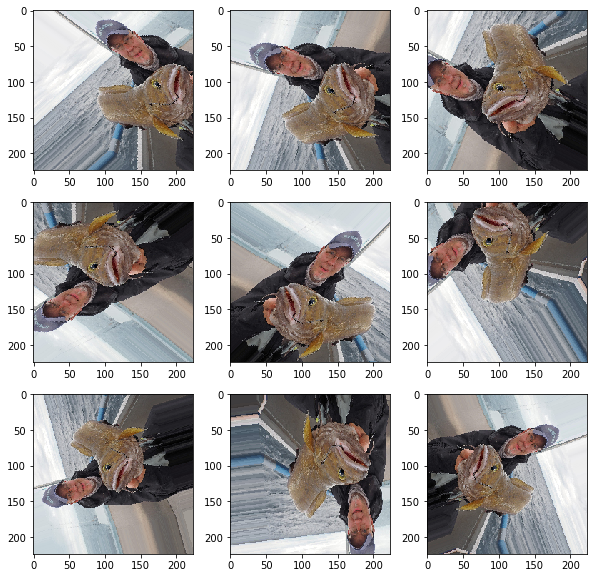

In [6]:
datagen = ImageDataGenerator(rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2
    )
from keras.preprocessing import image
img = image.load_img("images/kusk fish/41. 4b2875f367758fea698bda68320fd43c.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

fig = plt.figure(figsize=(10,10))
i = 1
images_list = []
for X_batch in datagen.flow(normalize_image(x)):
    for imag in X_batch:
        images_list.append(imag)
    i = i + 1
    if i>10:
        break
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images_list[i])

In [7]:
datagen = ImageDataGenerator(rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    #rescale=(1.0/255)
    #preprocessing_function=add_brightness
    )

In [8]:
labels = []
image_features = []

labels_test = []
image_features_test = []

images = []
image_count = 0
for idx,label in enumerate(os.listdir("images")):
    listdir = np.array(os.listdir("images/"+label))
    print(label,len(listdir))
    batch_sz = 100
    features = []
    labs = []
    label_batches = []
    
    labs_test = []
    label_batches_test = []
    count = 0
    for file in listdir:
        try:
            path = "images/"+label+'/'+file
            features.append(np.array(extract_image(path,model)[0]))
        except:
            count = count + 1
    print("Count is",count)
    temp_features = np.array(features)
    print(temp_features.shape)
    print("Done processing features")
    for i in range(int(len(listdir)/batch_sz)):
        X_features = temp_features[i*batch_sz:i*batch_sz+batch_sz]
        X_train, X_test, _, _ = train_test_split(X_features,np.ones(batch_sz,dtype='int'),test_size=0.1,random_state=1000)
        times = 0
        for X_batch in datagen.flow(X_train,batch_size=batch_sz):
                for aug_image in X_batch:
                    aug_image = preprocess_input(aug_image)
                    transformed_features = resnet_model(np.expand_dims(aug_image, axis=0))
                    label_batches.append(transformed_features)
                    labs.append(label)
                times = times + 1
                if times>1:
                    break
        for aug_image in X_train:
            aug_image = preprocess_input(aug_image)
            transformed_features = resnet_model(np.expand_dims(aug_image, axis=0))
            label_batches.append(transformed_features)
            labs.append(label)
        for aug_image in X_test:
            images.append(aug_image)
            aug_image = preprocess_input(aug_image)
            transformed_features = resnet_model(np.expand_dims(aug_image, axis=0))
            label_batches_test.append(transformed_features)
            labs_test.append(label)
        
    image_features = image_features + label_batches
    labels = labels + labs

    image_features_test = image_features_test + label_batches_test
    labels_test = labels_test + labs_test
    print(len(image_features_test))
    print(len(images))

cod caught 717
Count is 0
(717, 224, 224, 3)
Done processing features
70
70
out of water halibut 611
Count is 2
(609, 224, 224, 3)
Done processing features
130
130
kusk fish 351


/home/parmeet/anaconda3/lib/python3.6/site-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Count is 0
(351, 224, 224, 3)
Done processing features
160
160
fresh caught jonah crab 420
Count is 0
(420, 224, 224, 3)
Done processing features
200
200
caught lobster 573
Count is 0
(573, 224, 224, 3)
Done processing features
250
250


In [9]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(labels),labels)

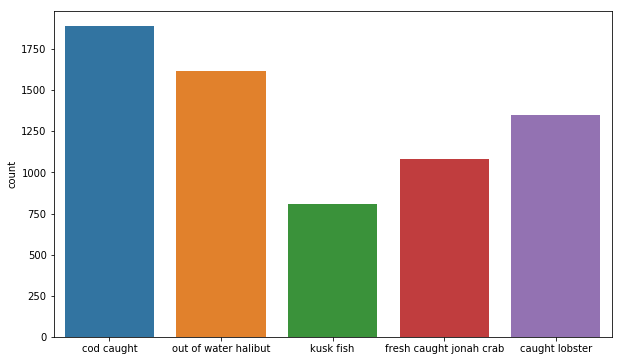

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(labels)

In [11]:
num_labels = len(np.unique(labels))

In [12]:
image_f = np.squeeze(np.array(image_features),axis=1)
image_f_test = np.squeeze(np.array(image_features_test),axis=1)

In [13]:
num_of_train_examples = image_f.shape
print(num_of_train_examples)
num_of_test_examples = image_f_test.shape
print(num_of_test_examples)

(6750, 2048)
(250, 2048)


In [14]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [15]:
le.fit(list(labels)+list(labels_test))
#le.fit(list(labels))
le_labels = le.transform(labels)
le_labels_test = le.transform(labels_test)
one = preprocessing.OneHotEncoder()
#one.fit(list(le_labels.reshape(-1,1)))
one.fit(list(le_labels.reshape(-1,1))+list(le_labels_test.reshape(-1,1)))
one_labels = one.transform(le_labels.reshape(-1,1))
one_labels_test = one.transform(le_labels_test.reshape(-1,1))

In [16]:
image_f_test.shape

(250, 2048)

In [17]:
image_input = Input(shape=(2048,))
img_input = BatchNormalization()(image_input)
img_input = Dense(2048,activation='relu')(img_input)
img_input = BatchNormalization()(img_input)
output = Dense(num_labels,activation='softmax')(img_input)
model_dense = Model(image_input, output)
model_dense.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_dense.save_weights('resnet-augmentation.hd5')

In [18]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True,random_state=1000)
test_cvscores = []
validation_cvscores = []

fusion_model_info = []

for train, test in kf.split(image_f):
    model_dense.load_weights('resnet-augmentation.hd5')
    hist = model_dense.fit(image_f[train], one_labels[train], epochs=20, verbose=1,class_weight=class_weights)
    print(hist.history['loss'])
    validation_score = model_dense.evaluate(image_f[test], one_labels[test], verbose=0)
    test_score = model_dense.evaluate(image_f_test, one_labels_test, verbose=0)
    predictions = model_dense.predict(image_f_test, verbose=0)
    predictions_validation = model_dense.predict(image_f[test], verbose=0)
    fusion_model_info.append([predictions_validation,one_labels[test],predictions,one_labels_test])
    pred_labels = np.argmax(predictions,axis=1)
    predicted_labels = le.inverse_transform(pred_labels)
    #print(labels[test])
    test_cvscores.append(test_score)
    validation_cvscores.append(validation_score)

Epoch 1/20
5400/5400 [==============================] - 2s 374us/step - loss: 1.2545 - acc: 0.7541
Epoch 2/20
5400/5400 [==============================] - 2s 298us/step - loss: 0.3043 - acc: 0.8983
Epoch 3/20
5400/5400 [==============================] - 2s 279us/step - loss: 0.1680 - acc: 0.9422
Epoch 4/20
5400/5400 [==============================] - 1s 276us/step - loss: 0.1227 - acc: 0.9541
Epoch 5/20
5400/5400 [==============================] - 1s 276us/step - loss: 0.1042 - acc: 0.9619
Epoch 6/20
5400/5400 [==============================] - 1s 277us/step - loss: 0.1076 - acc: 0.9639
Epoch 7/20
5400/5400 [==============================] - 1s 278us/step - loss: 0.0685 - acc: 0.9772
Epoch 8/20
5400/5400 [==============================] - 1s 275us/step - loss: 0.0628 - acc: 0.9778
Epoch 9/20
5400/5400 [==============================] - 1s 274us/step - loss: 0.0543 - acc: 0.9831
Epoch 10/20
5400/5400 [==============================] - 1s 275us/step - loss: 0.0595 - acc: 0.9807
Epoch 11/

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


5400/5400 [==============================] - 1s 277us/step - loss: 1.3806 - acc: 0.7306
Epoch 2/20
5400/5400 [==============================] - 1s 276us/step - loss: 0.3812 - acc: 0.8722
Epoch 3/20
5400/5400 [==============================] - 2s 281us/step - loss: 0.1926 - acc: 0.9296
Epoch 4/20
5400/5400 [==============================] - 1s 275us/step - loss: 0.0985 - acc: 0.9643
Epoch 5/20
5400/5400 [==============================] - 1s 276us/step - loss: 0.0636 - acc: 0.9787
Epoch 6/20
5400/5400 [==============================] - 2s 284us/step - loss: 0.0455 - acc: 0.9856
Epoch 7/20
5400/5400 [==============================] - 2s 279us/step - loss: 0.0397 - acc: 0.9870
Epoch 8/20
5400/5400 [==============================] - 1s 278us/step - loss: 0.0492 - acc: 0.9848
Epoch 9/20
5400/5400 [==============================] - 1s 275us/step - loss: 0.0611 - acc: 0.9807
Epoch 10/20
5400/5400 [==============================] - 2s 279us/step - loss: 0.0420 - acc: 0.9867
Epoch 11/20
5400/540

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


5400/5400 [==============================] - 1s 273us/step - loss: 1.3806 - acc: 0.7370
Epoch 2/20
5400/5400 [==============================] - 1s 272us/step - loss: 0.4280 - acc: 0.8524
Epoch 3/20
5400/5400 [==============================] - 1s 271us/step - loss: 0.2359 - acc: 0.9156
Epoch 4/20
5400/5400 [==============================] - 1s 272us/step - loss: 0.1276 - acc: 0.9567
Epoch 5/20
5400/5400 [==============================] - 1s 271us/step - loss: 0.0736 - acc: 0.9761
Epoch 6/20
5400/5400 [==============================] - 1s 272us/step - loss: 0.0496 - acc: 0.9837
Epoch 7/20
5400/5400 [==============================] - 2s 281us/step - loss: 0.0518 - acc: 0.9830
Epoch 8/20
5400/5400 [==============================] - 1s 271us/step - loss: 0.0507 - acc: 0.9830
Epoch 9/20
5400/5400 [==============================] - 1s 272us/step - loss: 0.0297 - acc: 0.9911
Epoch 10/20
5400/5400 [==============================] - 1s 272us/step - loss: 0.0259 - acc: 0.9933
Epoch 11/20
5400/540

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


5400/5400 [==============================] - 1s 271us/step - loss: 1.5223 - acc: 0.7306
Epoch 2/20
5400/5400 [==============================] - 1s 276us/step - loss: 0.4342 - acc: 0.8567
Epoch 3/20
5400/5400 [==============================] - 1s 274us/step - loss: 0.2295 - acc: 0.9207
Epoch 4/20
5400/5400 [==============================] - 2s 280us/step - loss: 0.1292 - acc: 0.9565
Epoch 5/20
5400/5400 [==============================] - 1s 271us/step - loss: 0.0691 - acc: 0.9761
Epoch 6/20
5400/5400 [==============================] - 1s 276us/step - loss: 0.0472 - acc: 0.9854
Epoch 7/20
5400/5400 [==============================] - 1s 270us/step - loss: 0.0342 - acc: 0.9902
Epoch 8/20
5400/5400 [==============================] - 1s 274us/step - loss: 0.0311 - acc: 0.9915
Epoch 9/20
5400/5400 [==============================] - 1s 273us/step - loss: 0.0298 - acc: 0.9902
Epoch 10/20
5400/5400 [==============================] - 1s 273us/step - loss: 0.0309 - acc: 0.9917
Epoch 11/20
5400/540

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


5400/5400 [==============================] - 2s 307us/step - loss: 1.5756 - acc: 0.7241
Epoch 2/20
5400/5400 [==============================] - 2s 330us/step - loss: 0.4156 - acc: 0.8598
Epoch 3/20
5400/5400 [==============================] - 2s 284us/step - loss: 0.2150 - acc: 0.9235
Epoch 4/20
5400/5400 [==============================] - 1s 272us/step - loss: 0.1038 - acc: 0.9635
Epoch 5/20
5400/5400 [==============================] - 1s 274us/step - loss: 0.0573 - acc: 0.9828
Epoch 6/20
5400/5400 [==============================] - 1s 268us/step - loss: 0.0548 - acc: 0.9815
Epoch 7/20
5400/5400 [==============================] - 1s 270us/step - loss: 0.0451 - acc: 0.9856
Epoch 8/20
5400/5400 [==============================] - 1s 271us/step - loss: 0.0367 - acc: 0.9876
Epoch 9/20
5400/5400 [==============================] - 1s 270us/step - loss: 0.0317 - acc: 0.9907
Epoch 10/20
5400/5400 [==============================] - 1s 270us/step - loss: 0.0279 - acc: 0.9920
Epoch 11/20
5400/540

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [23]:
print(np.mean(np.array(test_cvscores)[:,1]))
print(np.std(np.array(test_cvscores)[:,1]))

print(np.mean(np.array(validation_cvscores)[:,1]))
print(np.std(np.array(validation_cvscores)[:,1]))

with open("resnet.pckl","wb") as resnet:
    pickle.dump(fusion_model_info,resnet)

0.8159999993324281
0.011313708094375157
0.8687407407407408
0.005802416600760322


In [24]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
print(np.array(test_cvscores)[:,1]*100)

[83.20 80.00 80.80 82.40 81.60]


In [25]:
#print("Validation Standard Deviation",np.std(validation_cvscores))
print("Test Standard Deviation",np.std(test_cvscores))

Test Standard Deviation 0.1813250346886652


In [26]:
with open("resnet.pckl","rb") as incep:
    a = pickle.load(incep)

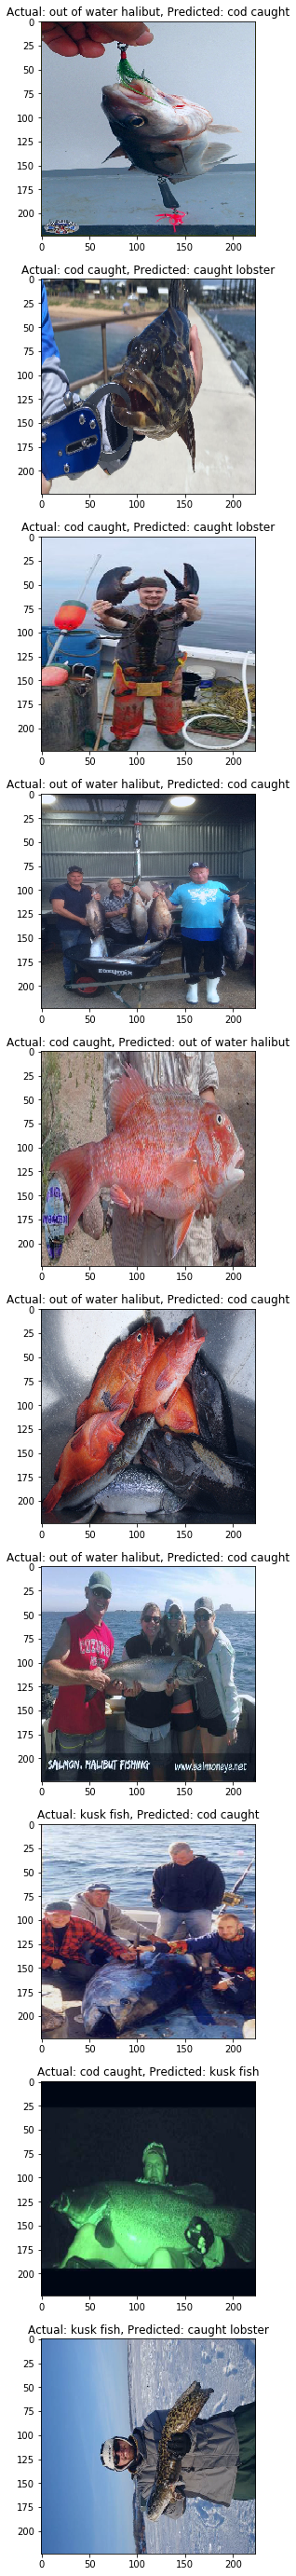

In [27]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = labels_test!=predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+labels_test[i]+', Predicted: '+predicted_labels[i])
plt.show()

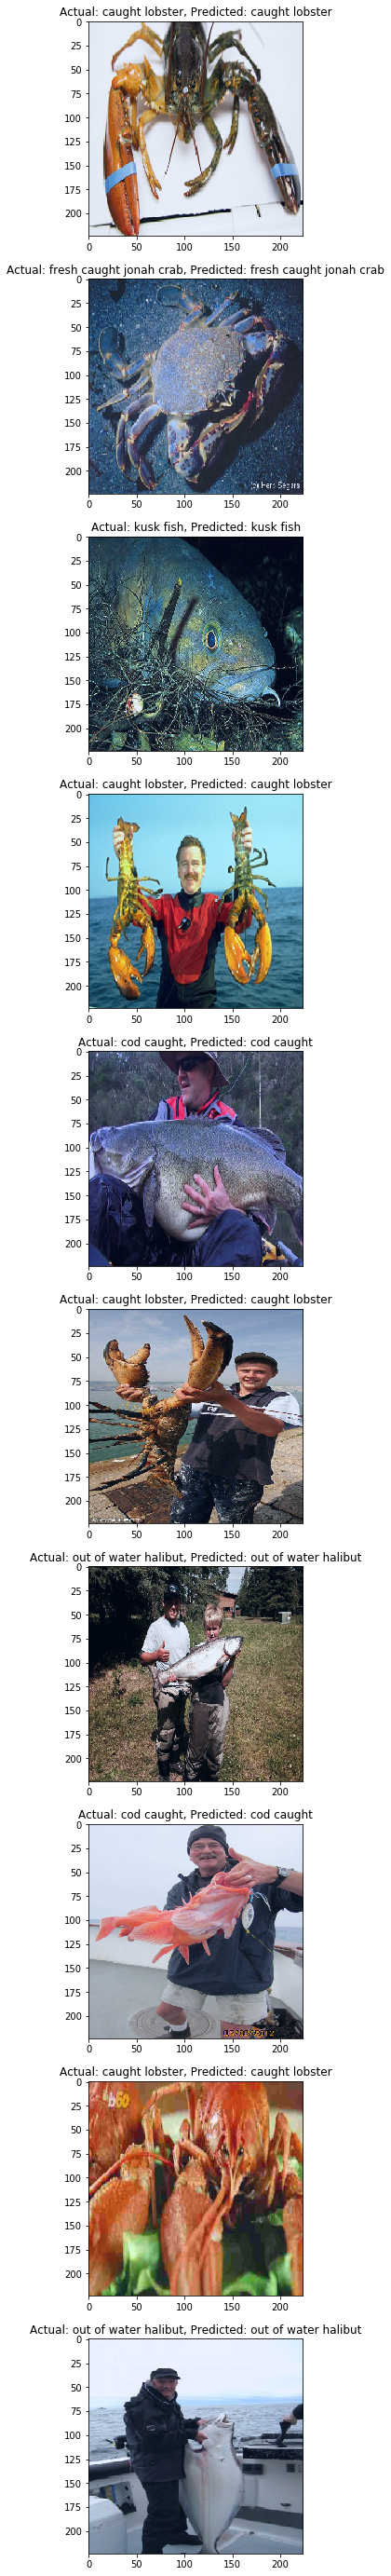

In [28]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)==predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    #ima = images[test[np.array(labels)[test]==predicted_labels][0]]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
    #print("Actual Label",np.array(labels)[test[eq_idx_list[i]]])
    #print("Predicted Label",predicted_labels[eq_idx_list[i]])
plt.show()

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predicted_labels,labels=np.unique(labels))
print(cm)

[[46  0  3  0  1]
 [ 3 56  0  4  7]
 [ 2  2 36  0  0]
 [ 2  5  0 21  2]
 [ 1 14  0  0 45]]


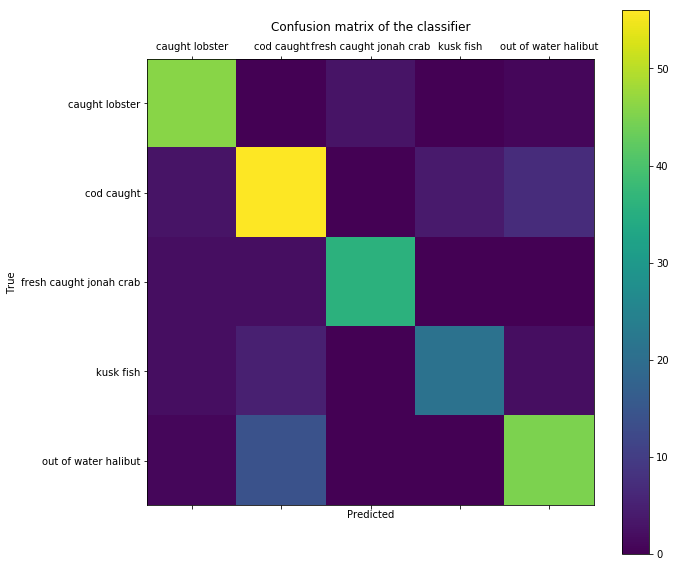

In [30]:
confusion_matrix(labels_test,predicted_labels)

labels_=list(np.unique(labels_test))
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_)
ax.set_yticklabels([''] + labels_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()